In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from direct_info import sort_di
import data_processing as dp

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

# import inference_dca for mfDCA
from inference_dca import direct_info_dca

# import pydca for plmDCA
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities

tools.hide_toggle()

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF00186'

pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# Read in Sequence Data
# data processing
s0,cols_removed,s_index,s_ipdb = dp.data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)
# Save processed data
msa_outfile, ref_outfile = dp.write_FASTA(s0,pfam_id,s_ipdb)

tools.hide_toggle()

number of pdb structures: 372
seq: 69
tpdb is now  56


Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 


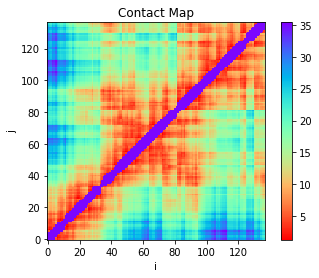

In [3]:
# Generate Contact Map
ct = tools.contact_map(pdb,ipdb,cols_removed,s_index)
ct_distal = tools.distance_restr(ct,s_index,make_large=True)
#--------------------------------------------------------------------#

plt.title('Contact Map')
plt.imshow(ct_distal,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

tools.hide_toggle()

In [44]:
#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    msa_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,

)

#start_time = timeit.default_timer()
#di_mf = direct_info_dca(s0)
#run_time = timeit.default_timer() - start_time
#print('MF run time:',run_time)

# Compute DCA scores using Mean Field DCA
start_time = timeit.default_timer()
sorted_DI_mf = mfdca_inst.compute_sorted_DI()
run_time = timeit.default_timer() - start_time
print('MF run time:',run_time)

N = mfdca_inst.sequences_len
B = mfdca_inst.num_sequences
print("sorted_DI (list) has shape: ",np.array(sorted_DI_mf).shape,"\nRows: all combinations of sequence postitions ie sequence len choose 2 ")
print("num sequences = %d , sequences len = %d\n\n"%(B,N))


tools.hide_toggle()

MF run time: 6.977994570001101
sorted_DI (list) has shape:  (9316, 2) 
Rows: all combinations of sequence postitions ie sequence len choose 2 
num sequences = 6610 , sequences len = 137




In [55]:
print("Print top 10 pairs")
count = 0
for site_pair, score in sorted_DI_mf[:10]:
    print(site_pair, score)
    if abs(site_pair[0] - site_pair[1])<5:
        sorted_DI_mf_dr[count] = site_pair,0
    count += 1

print("\n Re-sort and Print top 10 pairs w/ Distance Restraint")
sorted_DI_mf_dr = sorted(sorted_DI_mf, key=lambda x:x[1],reverse=True)
for site_pair,score in sorted_DI_mf_dr[:10]:
    print(site_pair,score)
    
    
# Generate Direct Information matrix
di_mf = np.zeros((N,N))
DI_ver= np.array(sorted_DI_mf)
for coupling in sorted_DI_mf:
    di_mf[coupling[0][0],coupling[0][1]] = coupling[1]
    di_mf[coupling[0][1],coupling[0][0]] = coupling[1]

print("\n\nCalculated DI: (shape, matrix)\n",di_mf.shape,"\n",di_mf[:6,:6])
np.save("mfDCA_DI_%s.npy"%(pfam_id),di_mf)

tools.hide_toggle()

Print top 10 pairs
(10, 105) 0.41320981530690126
(44, 60) 0.29548660003890453
(117, 120) 0
(4, 5) 0
(38, 39) 0
(6, 10) 0
(28, 43) 0.20408318596888492
(125, 126) 0
(7, 100) 0.1936054180676148
(4, 108) 0.18962431634012888

 Re-sort and Print top 10 pairs w/ Distance Restraint
(10, 105) 0.41320981530690126
(44, 60) 0.29548660003890453
(28, 43) 0.20408318596888492
(7, 100) 0.1936054180676148
(4, 108) 0.18962431634012888
(134, 136) 0.18506736870286972
(127, 128) 0.18118070882307763
(30, 79) 0.1792061885922991
(128, 129) 0.17918486555053692
(5, 9) 0.17850342556506565


Calculated DI: (shape, matrix)
 (137, 137) 
 [[0.         0.06458074 0.01829153 0.01045405 0.01343428 0.00763769]
 [0.06458074 0.         0.04062442 0.02845005 0.03954407 0.02495631]
 [0.01829153 0.04062442 0.         0.05028544 0.04973331 0.02550613]
 [0.01045405 0.02845005 0.05028544 0.         0.05233096 0.01934794]
 [0.01343428 0.03954407 0.04973331 0.05233096 0.         0.        ]
 [0.00763769 0.02495631 0.02550613 0.019

In [56]:
# find optimal threshold of distance for both DCA and ER
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

di_mf_dr = tools.distance_restr(di_mf,s_index,make_large=False)

auc_mf = np.zeros(n)

for i in range(n):
    p,tp,fp = tools.roc_curve(ct_distal,di_mf,ct_thres[i])
    auc_mf[i] = tp.sum()/tp.shape[0]
    
i0_mf = np.argmax(auc_mf)

p0_mf,tp0_mf,fp0_mf = tools.roc_curve(ct_distal,di_mf_dr,ct_thres[i0_mf])

tools.hide_toggle()

Dimensions of DI Pairs:
MF:  9316



	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


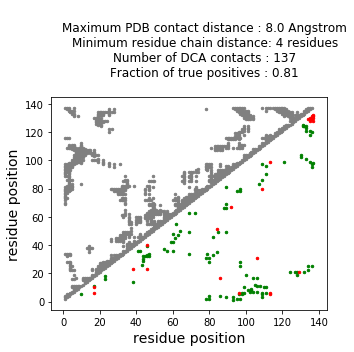


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


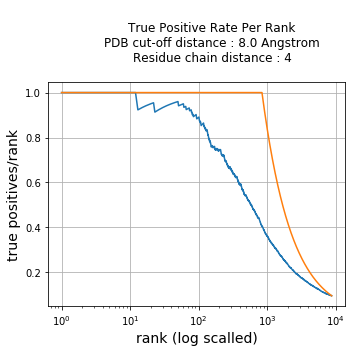

In [57]:
# Using PYDCA contact mapping module
print("Dimensions of DI Pairs:")
print("MF: ",len(sorted_DI_mf))

mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_mf,
    linear_dist = 4,
    contact_dist = 8.0,
)

mf_contact_map_data = mfdca_visualizer.plot_contact_map()

mf_tp_rate_data = mfdca_visualizer.plot_true_positive_rates()

tools.hide_toggle()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


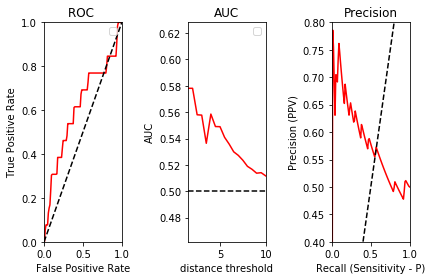

In [58]:
# Plot ROC for optimal DCA 

plt.subplot2grid((1,3),(0,0))
plt.title('ROC ')
plt.plot(fp0_mf,tp0_mf,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC')
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_mf,'r-')
plt.ylim([auc_mf.min()-0.05,auc_mf.max()+0.05])
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision')
plt.plot( p0_mf,tp0_mf / (tp0_mf + fp0_mf),'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
#plt.ylim([0,1])
plt.ylim([.4,.8])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()

In [59]:
# Generate Direct Information matrix
di_mf_DR = np.zeros((N,N))
for coupling in sorted_DI_mf_dr:
    di_mf[coupling[0][0],coupling[0][1]] = coupling[1]
    di_mf[coupling[0][1],coupling[0][0]] = coupling[1]

auc_mf_DR = np.zeros(n)

for i in range(n):
    p,tp,fp = tools.roc_curve(ct_distal,di_mf_DR,ct_thres[i])
    auc_mf[i] = tp.sum()/tp.shape[0]
    
i0_mf_DR = np.argmax(auc_mf_DR)

p0_mf_DR,tp0_mf_DR,fp0_mf_DR = tools.roc_curve(ct_distal,di_mf_DR,ct_thres[i0_mf_DR])

tools.hide_toggle()

Dimensions of DI Pairs:
MF:  9316



	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


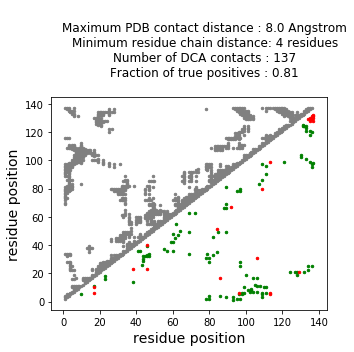


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


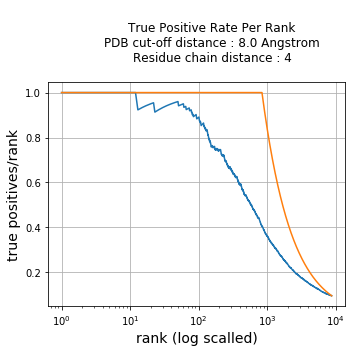

In [60]:
# Using PYDCA contact mapping module
print("Dimensions of DI Pairs:")
print("MF: ",len(sorted_DI_mf))

mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_mf_dr,
    linear_dist = 4,
    contact_dist = 8.0,
)

mf_contact_map_data = mfdca_visualizer.plot_contact_map()

mf_tp_rate_data = mfdca_visualizer.plot_true_positive_rates()

tools.hide_toggle()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


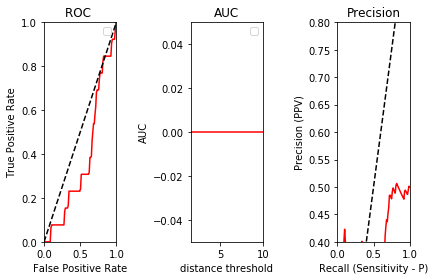

In [61]:
# Plot ROC for optimal DCA 

plt.subplot2grid((1,3),(0,0))
plt.title('ROC ')
plt.plot(fp0_mf_DR,tp0_mf_DR,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC')
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_mf_DR,'r-')
plt.ylim([auc_mf_DR.min()-0.05,auc_mf_DR.max()+0.05])
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision')
plt.plot( p0_mf_DR,tp0_mf_DR / (tp0_mf_DR + fp0_mf_DR),'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
#plt.ylim([0,1])
plt.ylim([.4,.8])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()